In [1]:
! pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import evaluate
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Load tokenizer and pretrained model
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
##tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")  # Replace with the actual Mamba model ID

# Load IMDb dataset

dataset = load_dataset("imdb", split="train")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [3]:
device = "cuda"

In [21]:
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = tokenizer.eos_token

def preprocess_function(examples):
    temp = tokenizer([item["text"] for item in examples], padding=True, truncation=True, return_tensors="pt")
    out = {}
    out["input_ids"] = temp["input_ids"].to(device)
    out["attention_mask"] = temp["attention_mask"].to(device)
    out["labels"] = torch.tensor([item["label"] for item in examples], device=device)
    return out
# tokenized_imdb = dataset.map(preprocess_function, batched=True)

In [5]:
# print(tokenized_imdb[0].keys())

In [6]:
# Tokenize the dataset

# def tokenize_function(examples):
#     return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
# tokenized_dataset = dataset.map(tokenize_function, batched=True)
# Set up data loader with collate_fn to ensure tensors are returned


# def collate_fn(batch):
#     for d in batch:
#       print(len(d["input_ids"]), len(d["attention_mask"]))
#     input_ids = torch.tensor([item["input_ids"] for item in batch])
#     attention_mask = torch.tensor([item["attention_mask"] for item in batch])
#     labels = torch.tensor([item["label"] for item in batch])
#     return {"input_ids": input_ids, "attention_mask":attention_mask,  "labels": labels}
dataloader = DataLoader(dataset, batch_size=16, collate_fn=preprocess_function, shuffle = True)

In [7]:
i = 0
for batch in dataloader:
  print(batch["input_ids"].device)
  print(batch["labels"].device)
  i +=1
  if i == 3:
    break

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [8]:
pad_token_id = tokenizer.convert_tokens_to_ids('<|endoftext|>')
tokenizer.pad_token_id, pad_token_id

(50256, 50256)

In [9]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [10]:

model = AutoModelForSequenceClassification.from_pretrained('EleutherAI/gpt-neo-125M', pad_token_id=tokenizer.pad_token_id, num_labels=2, id2label=id2label, label2id=label2id).to(device)
# model.eval()  # Set model to evaluation mode
print(model.device)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda:0


In [11]:
for param in model.transformer.parameters():
  param.requires_grad = False

In [12]:
for p in model.score.parameters():
  print(p.data.numel())

1536


In [13]:
for param in model.parameters():
  if param.requires_grad:
    print(param.data.numel())

1536


In [110]:
model

GPTNeoForSequenceClassification(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj)

In [14]:
epochs = 3
lr=1e-3
weight_decay = 0.01

In [15]:
optimizer = torch.optim.AdamW(model.score.parameters(), lr=lr, weight_decay=weight_decay)

In [16]:
accuracy_metric = evaluate.load("accuracy")

In [17]:
total_loss = 0
num_batches = 0
for epoch in range(epochs):
  for idx, batch in enumerate(dataloader):
    # input_ids = batch["input_ids"].to(device)
    # attention_mask = batch["attention_mask"].to(device)
    logits = model(**batch).logits
    loss = torch.nn.functional.cross_entropy(logits, batch["labels"])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # acc = accuracy_metric.compute(predictions=logits.argmax(dim=-1), references=batch["labels"])['accuracy']

    total_loss += loss.item()
    num_batches += 1
    if idx % 10 == 0:
      print("epoch:", epoch, " ---- iteration:", idx, " ---- loss:", total_loss/num_batches)
      total_loss = 0
      num_batches = 0

epoch: 0  ---- iteration: 0  ---- loss: 0.7364692091941833
epoch: 0  ---- iteration: 10  ---- loss: 0.7042431324720383
epoch: 0  ---- iteration: 20  ---- loss: 0.5615082561969758
epoch: 0  ---- iteration: 30  ---- loss: 0.5691649347543717
epoch: 0  ---- iteration: 40  ---- loss: 0.4687653139233589
epoch: 0  ---- iteration: 50  ---- loss: 0.4758991688489914
epoch: 0  ---- iteration: 60  ---- loss: 0.5002368867397309
epoch: 0  ---- iteration: 70  ---- loss: 0.4546749949455261
epoch: 0  ---- iteration: 80  ---- loss: 0.5197295248508453
epoch: 0  ---- iteration: 90  ---- loss: 0.5348368585109711
epoch: 0  ---- iteration: 100  ---- loss: 0.5269549489021301
epoch: 0  ---- iteration: 110  ---- loss: 0.4944182574748993
epoch: 0  ---- iteration: 120  ---- loss: 0.48983676433563234
epoch: 0  ---- iteration: 130  ---- loss: 0.4659353643655777
epoch: 0  ---- iteration: 140  ---- loss: 0.36403015851974485
epoch: 0  ---- iteration: 150  ---- loss: 0.4041626125574112
epoch: 0  ---- iteration: 160  --

In [19]:
test_dataset = load_dataset("imdb", split="test")

In [20]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, return_tensors="pt")


In [22]:
# tokenized_imdb = test_dataset.map(preprocess_function, batched=True)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=preprocess_function)

In [24]:
# Define metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
# Initialize lists for storing results
all_predictions = []
all_labels = []
total_loss = 0
# Evaluate model
with torch.no_grad():  # Disable gradient computation
    for idx, batch in enumerate(test_loader):
        # Forward pass
        outputs = model(**batch)
        logits = outputs.logits
        loss = outputs.loss
        # Accumulate loss
        total_loss += loss.item()
        # Get predictions and true labels
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        # Store predictions and labels for metric calculation
        all_predictions.extend(predictions.flatten())
        all_labels.extend(labels.flatten())

print(all_predictions)
print(len(all_predictions))
print("===============")
print(len(all_labels))
print(all_labels)

# Calculate average loss
avg_loss = total_loss / len(test_loader)
# Calculate accuracy and F1 score
accuracy = accuracy_metric.compute(predictions=all_predictions, references=all_labels)["accuracy"]
f1 = f1_metric.compute(predictions=all_predictions, references=all_labels, average="weighted")["f1"]
# Print results
print(f"Average Loss: {avg_loss}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

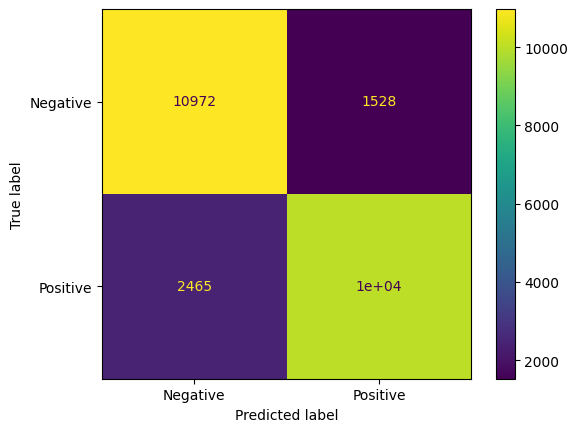

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions, labels = [0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
# Define the save directory in Google Drive
save_directory = '/content/drive/MyDrive/NLP/Project'

In [46]:
# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer if it’s customized or essential for model loading
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/NLP/Project/tokenizer_config.json',
 '/content/drive/MyDrive/NLP/Project/special_tokens_map.json',
 '/content/drive/MyDrive/NLP/Project/vocab.json',
 '/content/drive/MyDrive/NLP/Project/merges.txt',
 '/content/drive/MyDrive/NLP/Project/added_tokens.json',
 '/content/drive/MyDrive/NLP/Project/tokenizer.json')

In [48]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer from Google Drive
new_tokenizer = AutoTokenizer.from_pretrained(save_directory)
new_model = AutoModelForSequenceClassification.from_pretrained(save_directory).to(device)

In [54]:
# outputs = new_model(**batch)
# outputs.logits.shape, outputs.loss